In [36]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# Lets check your GPU
if tf.config.list_logical_devices('GPU') != []:
    print("LET'S DO THISS!!! :DDDD")
else: 
    print("Oh dude... D:")

LET'S DO THISS!!! :DDDD


In [37]:
# extra code – loads, scales, and splits the fashion MNIST dataset
fashion_mnist = tf.keras.datasets.mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

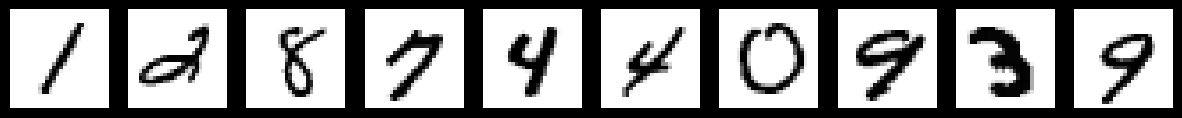

In [38]:
import numpy as np

def plot_images(images=X_valid, n_images=5):
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")

plot_images(n_images=10)
plt.show()

## Create Model

In [39]:
class Discriminator(keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.inputs_ = keras.Input(shape=[28, 28, 1])
        self.conv2d_1 = keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same")
        self.leakyrelu_1 = keras.layers.LeakyReLU(alpha=0.2)
        self.conv2d_2 = keras.layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same")
        self.leakyrelu_2 = keras.layers.LeakyReLU(alpha=0.2)
        self.globalmp_1 = keras.layers.GlobalMaxPooling2D()
        self.dense_output = keras.layers.Dense(1)
        # self.name = "discriminator"
    
    def call(self, inputs, training=False):
        x = self.conv2d_1(inputs)
        x = self.leakyrelu_1(x)
        x = self.conv2d_2(x)
        x = self.leakyrelu_2(x)
        x = self.globalmp_1(x)
        return self.dense_output(x)
    
class Generator(keras.Model):
    def __init__(self, latent_dim=128):
        super(Generator, self).__init__()
        self.input_ = keras.Input(shape=(latent_dim,))
        self.dense_1 = keras.layers.Dense(7 * 7 * 128)
        self.leakyrelu_0 = keras.layers.LeakyReLU(alpha=0.2)
        self.reshape_1 = keras.layers.Reshape([7, 7, 128])
        self.conv2dtr_1 = keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same")
        self.leakyrelu_1 = keras.layers.LeakyReLU(alpha=0.2)
        self.conv2dtr_2 = keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same")
        self.leakyrelu_2 = keras.layers.LeakyReLU(alpha=0.2)
        self.conv2d = keras.layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid")
        # self.name = "generator"
        
    def call(self, inputs, training=False):
        x = self.dense_1(inputs)
        x = self.leakyrelu_0(x)
        x = self.reshape_1(x)
        x = self.conv2dtr_1(x)
        x = self.leakyrelu_1(x)
        x = self.conv2dtr_2(x)
        x = self.leakyrelu_2(x)
        return self.conv2d(x)

In [40]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
            
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))
        
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        misleading_labels = tf.zeros((batch_size, 1))
        
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
            
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        
        return {"d_loss": d_loss, "g_loss": g_loss}

In [41]:
# estilo
plt.style.use('dark_background')
plt.rcParams['axes.facecolor'] = '#26262e' 

def plot_generated_images(generator, n_images=10):
    random_latent_vectors = tf.random.normal(shape=(n_images, latent_dim))
    generated_images = generator(random_latent_vectors)
    plt.figure(figsize=(n_images * 1.5, 3))
    for i in range(n_images):
        plt.subplot(1, n_images, i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap="binary")
        plt.axis("off")
    plt.show()

def plot_loss(history, step):
    plt.figure(figsize=(12, 4))
    plt.plot(list(range(len(history['d_loss']))), history['d_loss'], label='d_loss')
    plt.plot(list(range(len(history['g_loss']))), history['g_loss'], label='g_loss')
    plt.legend()
    plt.title(f"Epoch {step}")
    plt.show()

class LogCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.history = {'d_loss': [], 'g_loss': []}
    
    def on_epoch_end(self, epoch, logs=None):
        self.history['d_loss'].append(logs['d_loss'])
        self.history['g_loss'].append(logs['g_loss'])
        plot_loss(self.history, epoch)
        plot_generated_images(generator)

Epoch 1/20
1093/1094 [============================>.] - ETA: 0s - d_loss: 0.4589 - g_loss: 1.3812

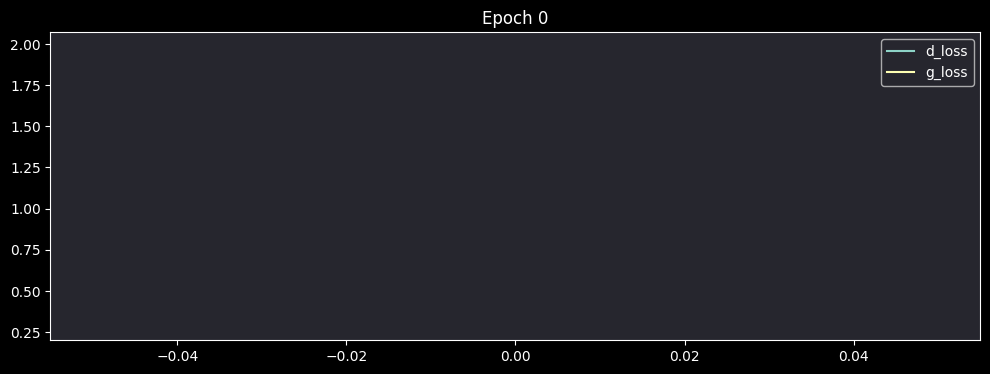

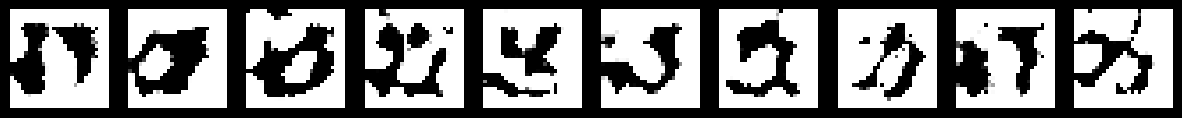

1094/1094 [==============================] - 41s 36ms/step - d_loss: 0.4586 - g_loss: 1.3823
Epoch 2/20
1093/1094 [============================>.] - ETA: 0s - d_loss: 0.2257 - g_loss: 3.2361

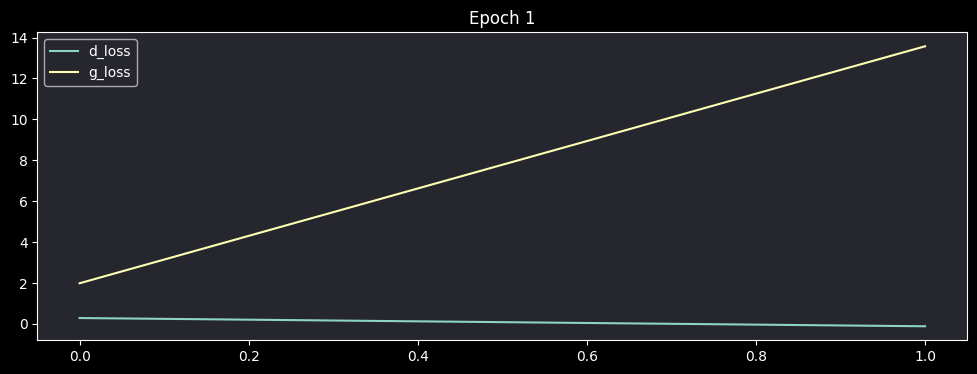

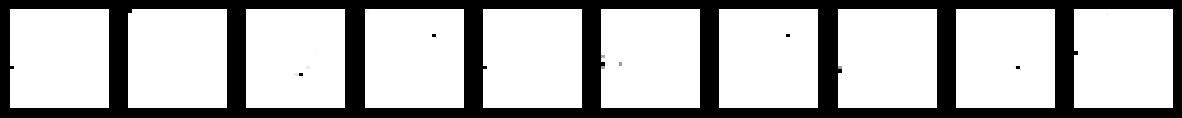

1094/1094 [==============================] - 41s 38ms/step - d_loss: 0.2251 - g_loss: 3.2550
Epoch 3/20
1093/1094 [============================>.] - ETA: 0s - d_loss: 0.5160 - g_loss: 2.6811

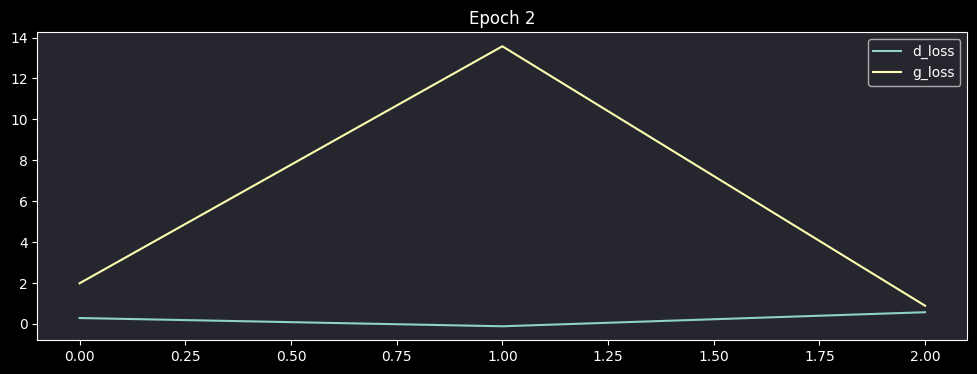

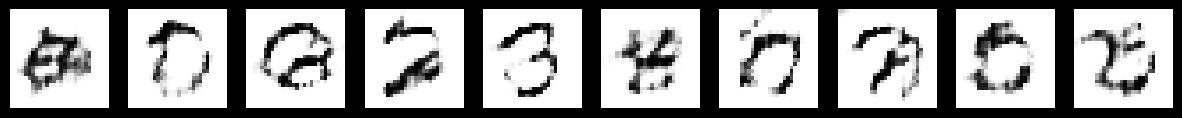

1094/1094 [==============================] - 42s 38ms/step - d_loss: 0.5161 - g_loss: 2.6779
Epoch 4/20
1094/1094 [==============================] - ETA: 0s - d_loss: 0.6628 - g_loss: 0.8989

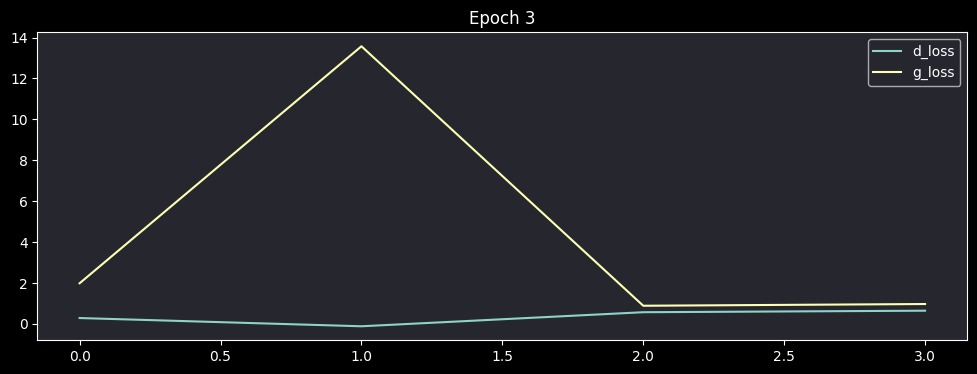

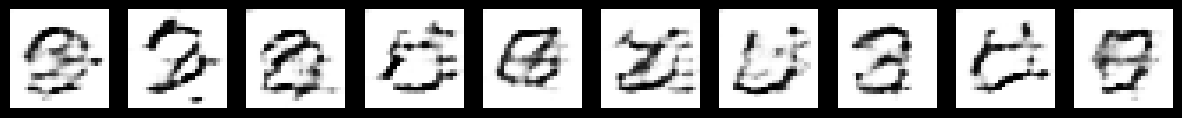

1094/1094 [==============================] - 42s 39ms/step - d_loss: 0.6628 - g_loss: 0.8990
Epoch 5/20
1093/1094 [============================>.] - ETA: 0s - d_loss: 0.6506 - g_loss: 0.8961

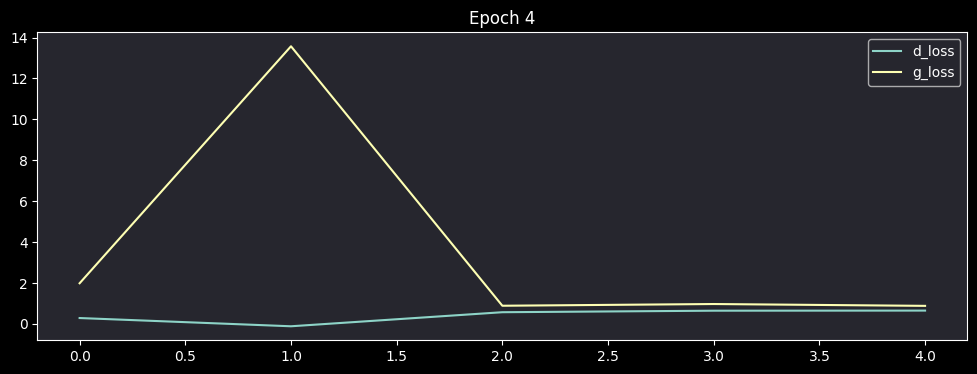

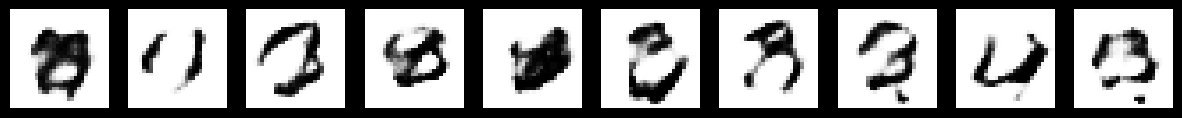

1094/1094 [==============================] - 42s 38ms/step - d_loss: 0.6506 - g_loss: 0.8961
Epoch 6/20
1093/1094 [============================>.] - ETA: 0s - d_loss: 0.6238 - g_loss: 0.9659

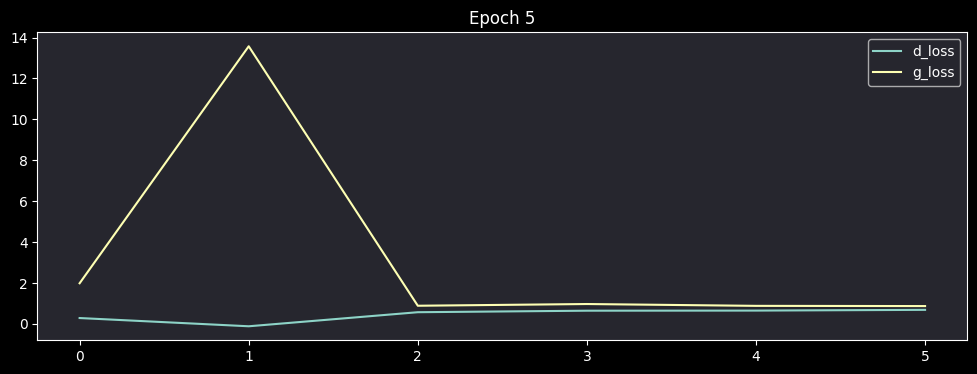

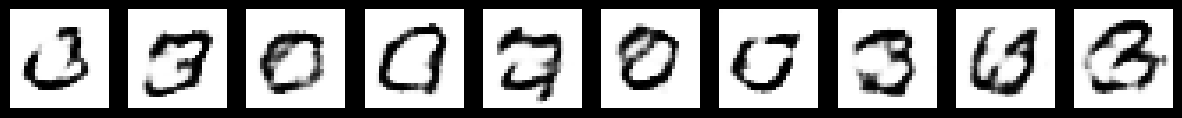

1094/1094 [==============================] - 43s 39ms/step - d_loss: 0.6239 - g_loss: 0.9657
Epoch 7/20
1093/1094 [============================>.] - ETA: 0s - d_loss: 0.6089 - g_loss: 0.9857

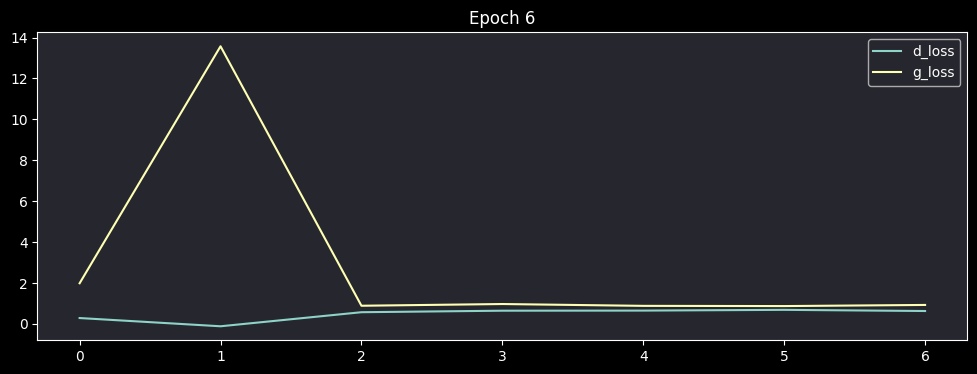

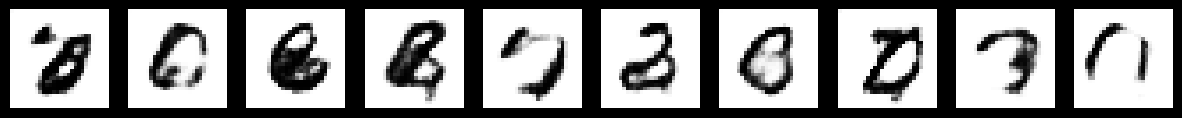

1094/1094 [==============================] - 43s 39ms/step - d_loss: 0.6089 - g_loss: 0.9856
Epoch 8/20
1093/1094 [============================>.] - ETA: 0s - d_loss: 0.5825 - g_loss: 1.0315

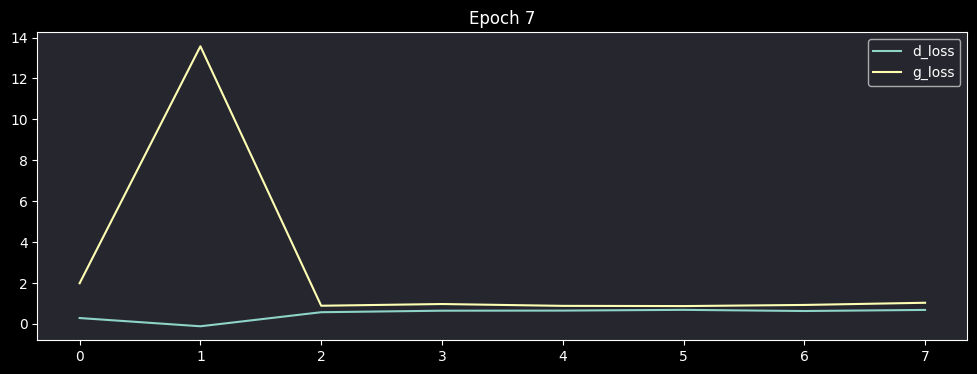

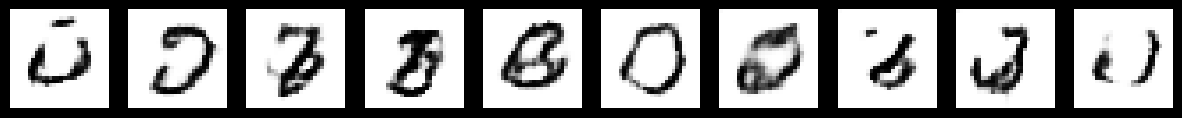

1094/1094 [==============================] - 42s 39ms/step - d_loss: 0.5827 - g_loss: 1.0315
Epoch 9/20
1093/1094 [============================>.] - ETA: 0s - d_loss: 0.5693 - g_loss: 1.0565

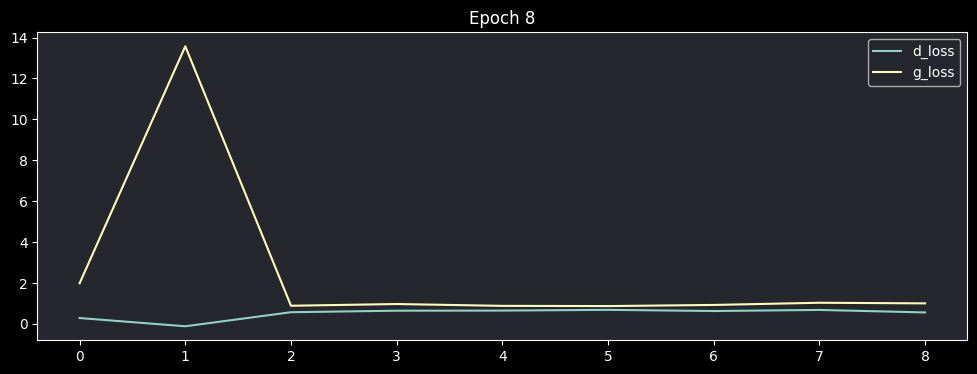

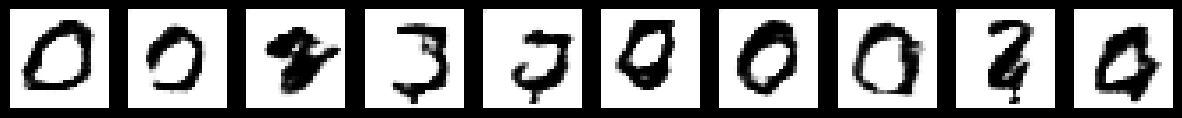

1094/1094 [==============================] - 44s 40ms/step - d_loss: 0.5692 - g_loss: 1.0564
Epoch 10/20
1093/1094 [============================>.] - ETA: 0s - d_loss: 0.5566 - g_loss: 1.0975

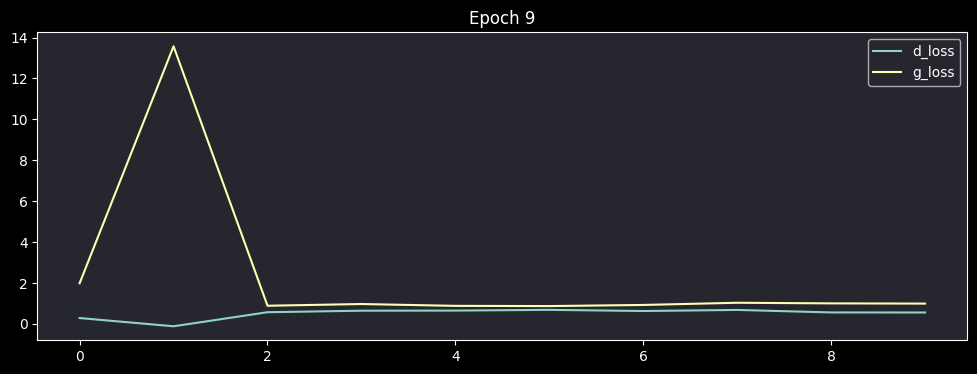

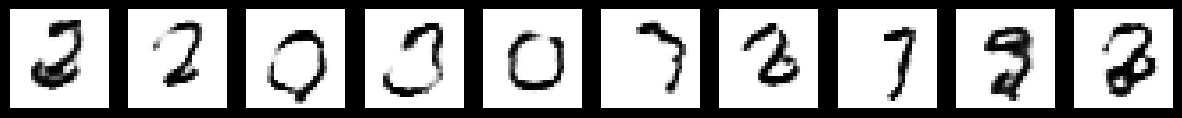

1094/1094 [==============================] - 42s 39ms/step - d_loss: 0.5566 - g_loss: 1.0973
Epoch 11/20
1093/1094 [============================>.] - ETA: 0s - d_loss: 0.5558 - g_loss: 1.1012

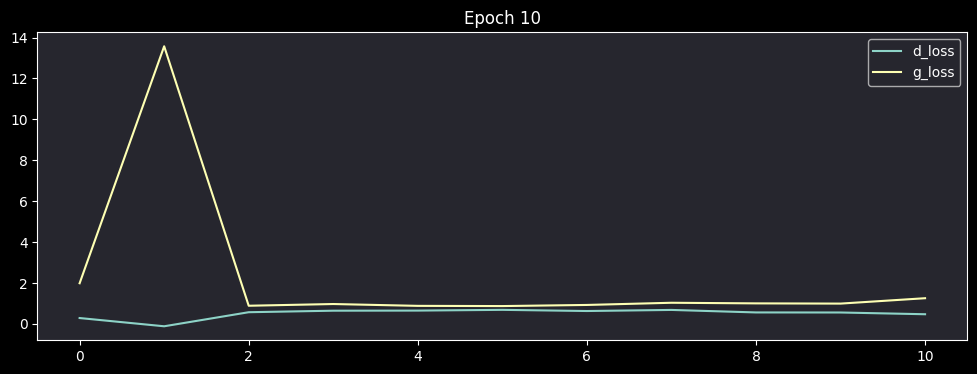

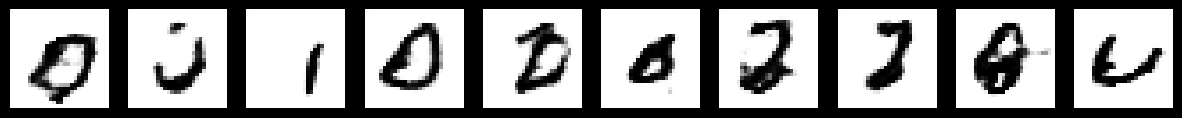

1094/1094 [==============================] - 43s 39ms/step - d_loss: 0.5556 - g_loss: 1.1014
Epoch 12/20
1093/1094 [============================>.] - ETA: 0s - d_loss: 0.5545 - g_loss: 1.1011

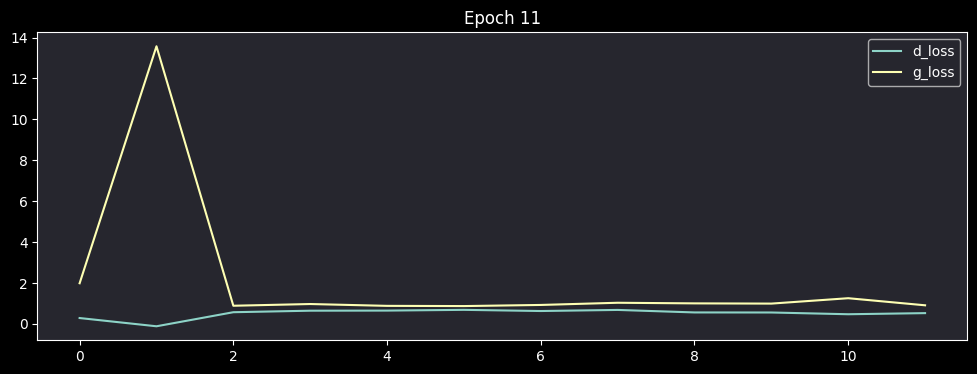

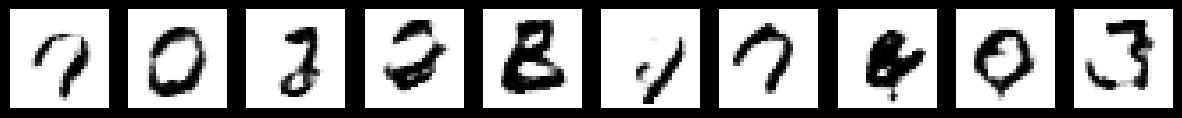

1094/1094 [==============================] - 43s 40ms/step - d_loss: 0.5544 - g_loss: 1.1008
Epoch 13/20
1093/1094 [============================>.] - ETA: 0s - d_loss: 0.5526 - g_loss: 1.1188

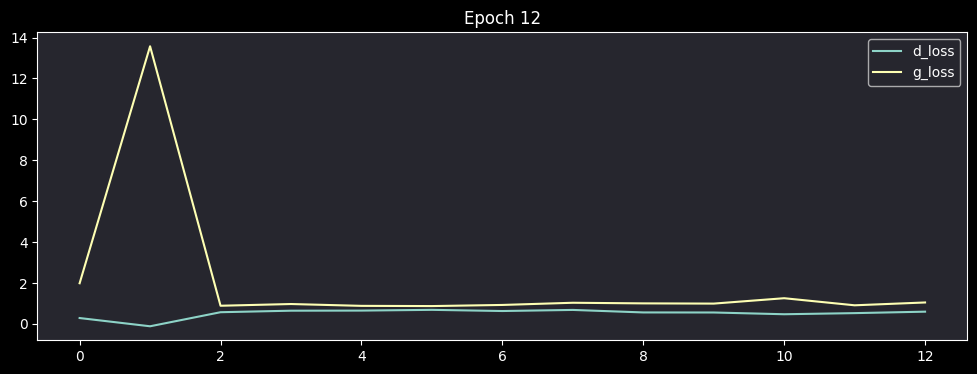

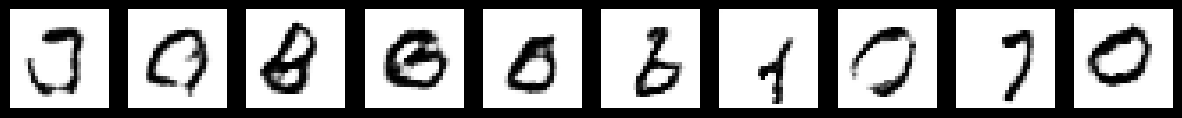

1094/1094 [==============================] - 43s 39ms/step - d_loss: 0.5527 - g_loss: 1.1187
Epoch 14/20
1094/1094 [==============================] - ETA: 0s - d_loss: 0.5604 - g_loss: 1.0831

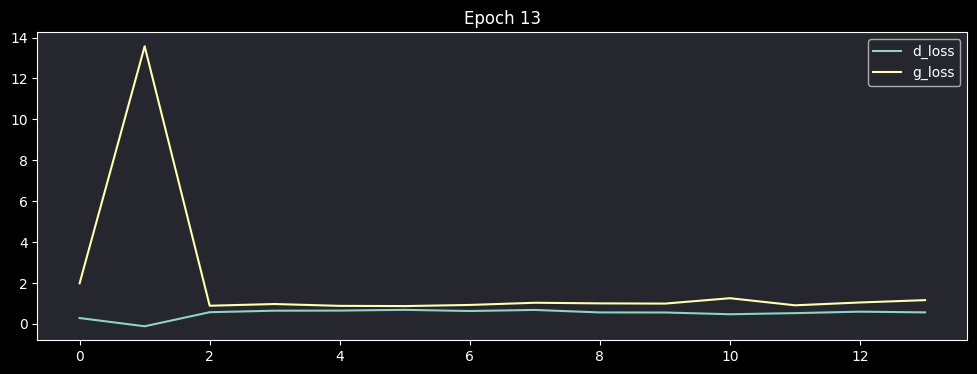

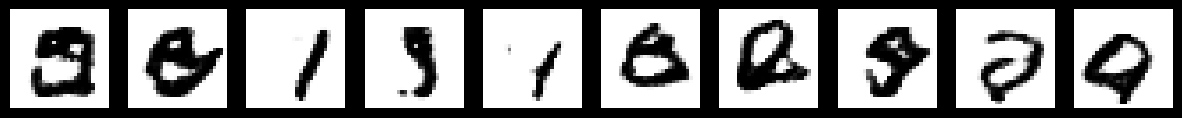

1094/1094 [==============================] - 43s 39ms/step - d_loss: 0.5604 - g_loss: 1.0832
Epoch 15/20
1093/1094 [============================>.] - ETA: 0s - d_loss: 0.5658 - g_loss: 1.0783

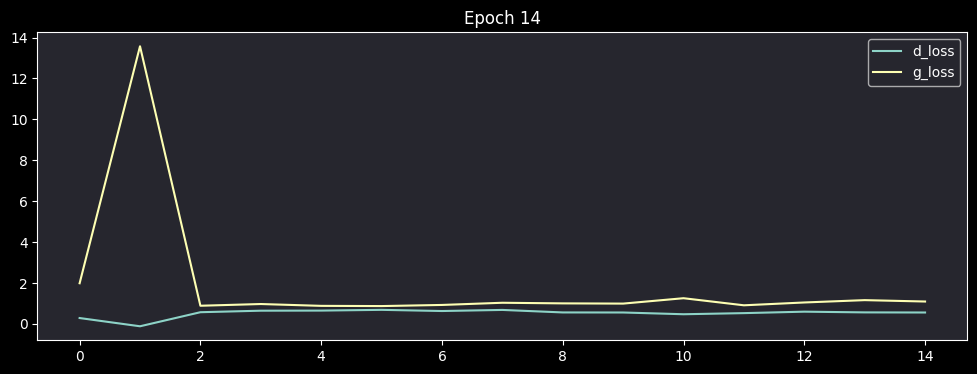

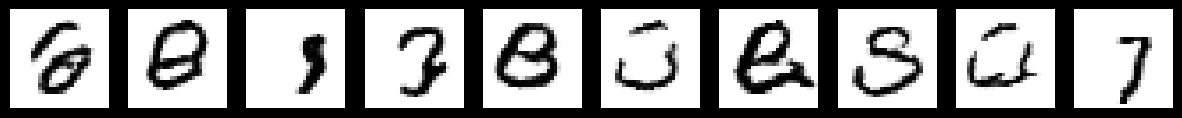

1094/1094 [==============================] - 43s 39ms/step - d_loss: 0.5658 - g_loss: 1.0783
Epoch 16/20
1093/1094 [============================>.] - ETA: 0s - d_loss: 0.5785 - g_loss: 1.0449

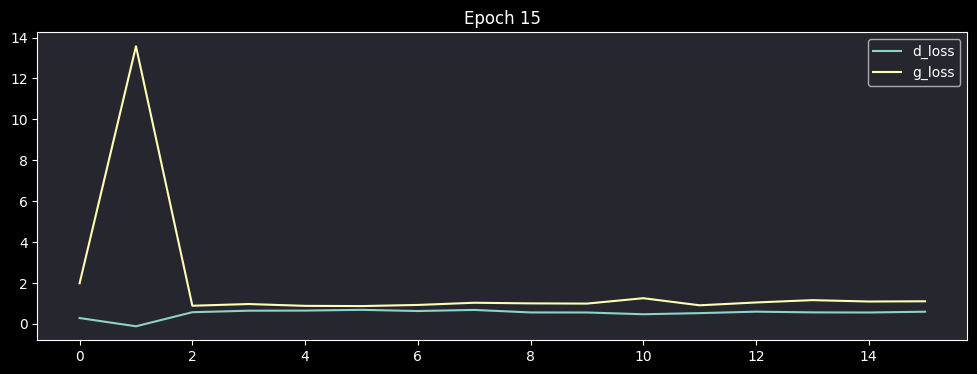

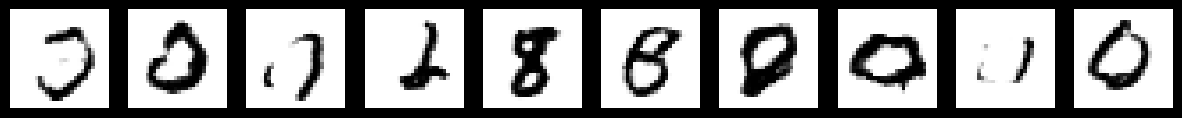

1094/1094 [==============================] - 42s 39ms/step - d_loss: 0.5785 - g_loss: 1.0451
Epoch 17/20
1094/1094 [==============================] - ETA: 0s - d_loss: 0.5877 - g_loss: 1.0261

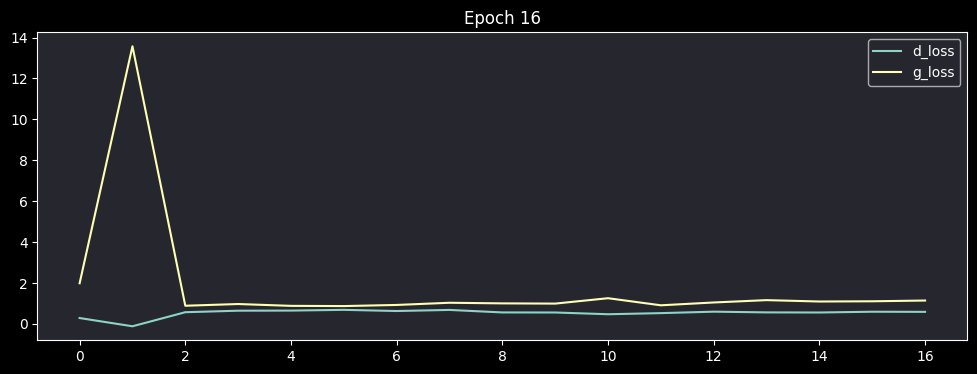

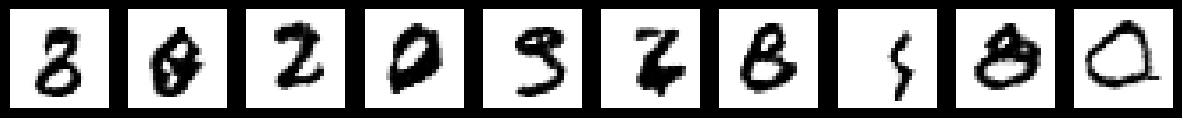

1094/1094 [==============================] - 43s 39ms/step - d_loss: 0.5877 - g_loss: 1.0262
Epoch 18/20
1093/1094 [============================>.] - ETA: 0s - d_loss: 0.5941 - g_loss: 1.0187

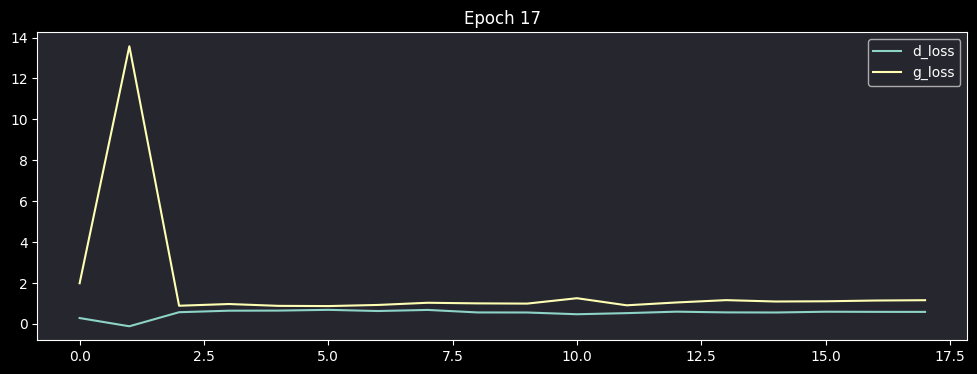

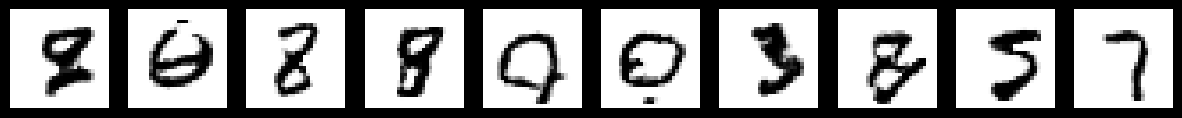

1094/1094 [==============================] - 43s 39ms/step - d_loss: 0.5940 - g_loss: 1.0189
Epoch 19/20
1093/1094 [============================>.] - ETA: 0s - d_loss: 0.5996 - g_loss: 1.0076

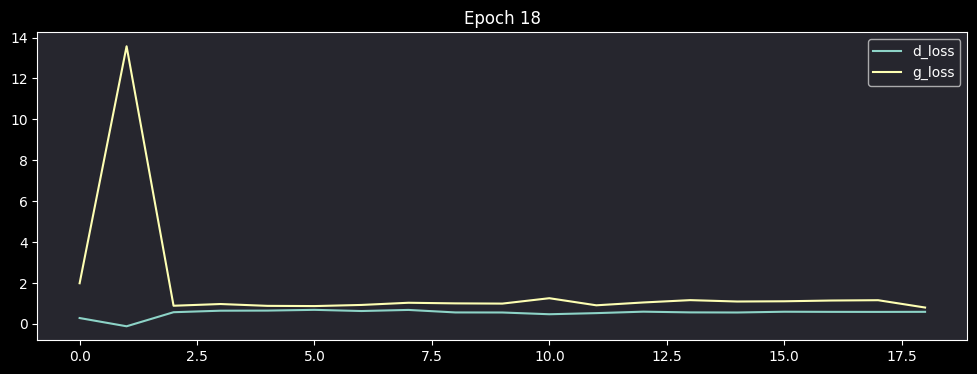

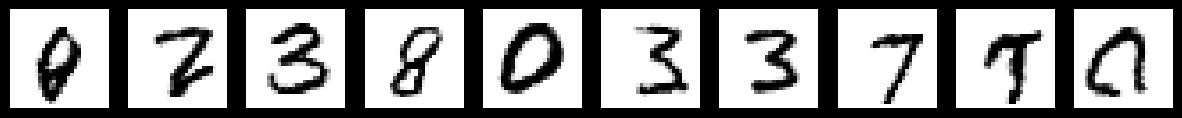

1094/1094 [==============================] - 44s 40ms/step - d_loss: 0.5996 - g_loss: 1.0073
Epoch 20/20
1093/1094 [============================>.] - ETA: 0s - d_loss: 0.6052 - g_loss: 0.9992

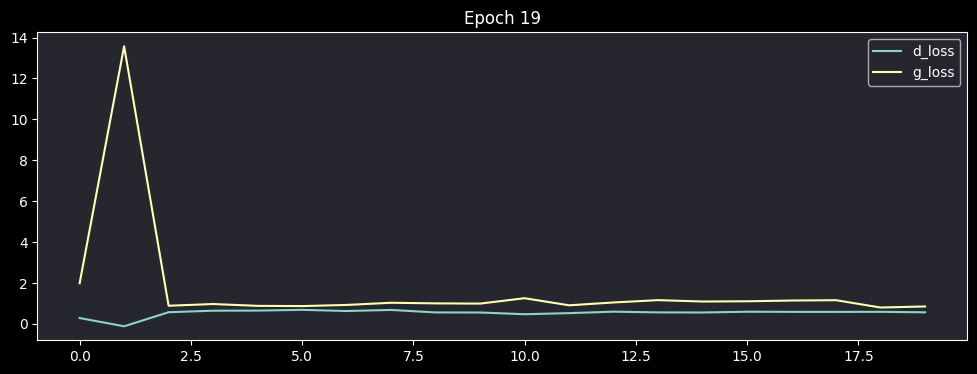

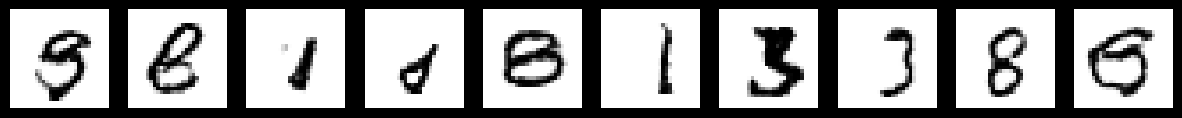

1094/1094 [==============================] - 43s 39ms/step - d_loss: 0.6052 - g_loss: 0.9989


In [42]:
# Prepare the dataset. We use both the training & test MNIST digits.
batch_size = 64
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

latent_dim = 128
discriminator = Discriminator()
generator = Generator(latent_dim=128)

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

gan.fit(dataset, epochs=20, callbacks=[LogCallback()])